In [ ]:
# requirements
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torch.autograd import Variable

# colab requirements
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep

import pickle as pk



# **Rebuild the GON network**

In [ ]:
# image data
dataset_name = 'mnist' # ['mnist', 'fashion']
img_size = 32
n_channels = 1
img_coords = 2

# training info
lr = 1e-4
batch_size = 64
nz = 128
ngf = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# create the GON network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, n_channels, 4, 2, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
      return self.main(input)

In [ ]:
# helper functions
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def slerp(a, b, t):
    omega = torch.acos((a/torch.norm(a, dim=1, keepdim=True)*b/torch.norm(b, dim=1, keepdim=True)).sum(1)).unsqueeze(1)
    res = (torch.sin((1.0-t)*omega)/torch.sin(omega))*a + (torch.sin(t*omega)/torch.sin(omega)) * b
    return res

def slerp_batch(model, z):
    lz = z.data.clone().squeeze(-1).squeeze(-1)
    col_size = int(np.sqrt(z.size(0)))
    src_z = lz.data[:col_size].repeat(col_size,1)
    z1, z2 = lz.data.split(lz.shape[0]//2)
    tgt_z = torch.cat([z2, z1])
    tgt_z = tgt_z[:col_size].repeat(col_size,1)
    t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).contiguous().view(batch_size,1).contiguous().to(device)
    z_slerp = slerp(src_z, tgt_z, t)
    g_slerp = model(z_slerp.unsqueeze(-1).unsqueeze(-1))
    return g_slerp

In [ ]:
# load datasets
if dataset_name == 'mnist':
    dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))
if dataset_name == 'fashion':
    dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
F = Generator().to(device)

optim = torch.optim.Adam(lr=lr, params=F.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(F.parameters()))}')

> Number of parameters 172625


In [ ]:
errror_list = []
#0-ELU
#1-relu
#2-tanh
#3-leakyrelu
#4-softplus

In [ ]:
val_error = 0
#error = []
for step in range(501):
    verror = 0
    for i, batch in enumerate(train_loader,1):
    # sample a batch of data
      x = batch[0].to(device)
    #x = x.to(device)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
      z = torch.zeros(batch_size, nz, 1, 1).to(device).requires_grad_()
    
      g = F(z)
      L_inner = ((g - x)**2).sum(1).mean()
    #print([z])
      grad = torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
      z = (-grad)

    # now with z as our new latent points, optimise the data fitting loss
      g = F(z)
      L_outer = ((g - x)**2).sum(1).mean()
      optim.zero_grad()
      L_outer.backward()
      optim.step()

      verror +=L_outer.item()
      
        #error.append(L_outer.item())
        
        # plot reconstructions and interpolations
        #recons = torchvision.utils.make_grid(torch.clamp(g, 0, 1), padding=0, nrow=8)
        #slerps = torchvision.utils.make_grid(torch.clamp(slerp_batch(F, z.data), 0, 1), padding=0, nrow=8)

        #clear_output()
        #plt.title('Reconstructions')
        #plt.imshow(recons[0,:,:].reshape(256,256,1).repeat(1,1,3).cpu().data.numpy())
        #plt.figure()
        #plt.title('Spherical Interpolations')
        #plt.imshow(slerps[0,:,:].reshape(256,256,1).repeat(1,1,3).cpu().data.numpy())
        #plt.show()
        #sleep(1)

    #if step == 20:
      #errror_list.append(error)
    print(f"Step: {step}   Loss: {verror:.3f}")

Step: 0   Loss: 47.608
Step: 1   Loss: 6.844
Step: 2   Loss: 2.834
Step: 3   Loss: 1.880
Step: 4   Loss: 1.505
Step: 5   Loss: 1.310
Step: 6   Loss: 1.192
Step: 7   Loss: 1.110
Step: 8   Loss: 1.051
Step: 9   Loss: 1.001
Step: 10   Loss: 0.963
Step: 11   Loss: 0.933
Step: 12   Loss: 0.906
Step: 13   Loss: 0.881
Step: 14   Loss: 0.863
Step: 15   Loss: 0.845
Step: 16   Loss: 0.830
Step: 17   Loss: 0.815
Step: 18   Loss: 0.803
Step: 19   Loss: 0.791
Step: 20   Loss: 0.780
Step: 21   Loss: 0.770
Step: 22   Loss: 0.761
Step: 23   Loss: 0.751
Step: 24   Loss: 0.743
Step: 25   Loss: 0.735
Step: 26   Loss: 0.727
Step: 27   Loss: 0.719
Step: 28   Loss: 0.713
Step: 29   Loss: 0.705
Step: 30   Loss: 0.699
Step: 31   Loss: 0.692
Step: 32   Loss: 0.686
Step: 33   Loss: 0.680
Step: 34   Loss: 0.674
Step: 35   Loss: 0.669
Step: 36   Loss: 0.663
Step: 37   Loss: 0.658
Step: 38   Loss: 0.654
Step: 39   Loss: 0.648
Step: 40   Loss: 0.644
Step: 41   Loss: 0.639
Step: 42   Loss: 0.634
Step: 43   Loss: 0.6

[[0.20246434211730957, 0.1365395337343216, 0.09581667184829712, 0.07292069494724274, 0.055144406855106354, 0.04478691518306732, 0.03724741190671921, 0.0319909043610096, 0.027923818677663803, 0.024923328310251236, 0.022959914058446884, 0.02018573507666588, 0.01894807070493698, 0.018868131563067436, 0.015513600781559944, 0.014698861166834831, 0.014297479763627052, 0.012500494718551636, 0.01209699921309948, 0.010687154717743397], [0.1742669939994812, 0.13185542821884155, 0.10435635596513748, 0.0849505290389061, 0.06906407326459885, 0.05932934209704399, 0.05091971904039383, 0.04298257455229759, 0.03673141449689865, 0.03252428397536278, 0.029288649559020996, 0.025622863322496414, 0.022313300520181656, 0.02035333961248398, 0.017949260771274567, 0.01625588908791542, 0.015650365501642227, 0.01371743530035019, 0.012287994846701622, 0.011443639174103737], [0.15183979272842407, 0.11442144960165024, 0.0922088474035263, 0.07413429021835327, 0.06244497001171112, 0.0523531511425972, 0.043569650501012

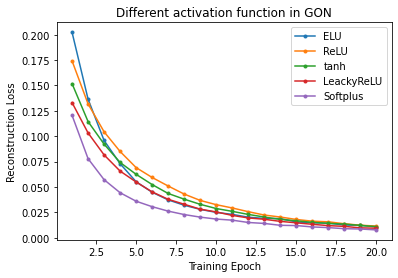

In [ ]:
print(errror_list)
training_l = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.title('Different activation function in GON')
plt.xlabel('Training Epoch')
plt.ylabel('Reconstruction Loss')
plt.plot(training_l, errror_list[0], marker = 'o', markersize = 3)
plt.plot(training_l, errror_list[1], marker = 'o', markersize = 3)
plt.plot(training_l, errror_list[2], marker = 'o', markersize = 3)
plt.plot(training_l, errror_list[3], marker = 'o', markersize = 3)
plt.plot(training_l, errror_list[4], marker = 'o', markersize = 3)

plt.legend(['ELU', 'ReLU','tanh', 'LeackyReLU', 'Softplus'])
plt.show()

In [ ]:
if dataset_name == 'mnist':
    testset = torchvision.datasets.MNIST('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
if dataset_name == 'fashion':
    testset = torchvision.datasets.FashionMNIST('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)


print(testset)
test_iterator = iter(cycle(testloader))

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [ ]:
#F.eval()
test_loss = 0

loss = nn.MSELoss()

#with torch.no_grad():

x, t = next(test_iterator)
x, t = x.to(device), t.to(device)
z = torch.zeros(batch_size, nz, 1, 1).to(device).requires_grad_()
z.requires_grad = True
g = F(z)
L_inner = ((g - x)**2).sum(1).mean()
  #L_inner.requires_grad = True
    #print([z])
grad = torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True, allow_unused=True)[0]
  #print(grad)
z = -(grad)

    # now with z as our new latent points, optimise the data fitting loss
g = F(z)
L_outer = ((g - x)**2).sum(1).mean()
  #optim.zero_grad()

L_outer.backward()


  #print(L_outer)
  #print(t)
print(L_outer.item())
test_loss += L_outer.item()

#test_loss /= len(test_loader.dataset)
#test_losses.append(test_loss)
print(test_loss)

0.08086909353733063
0.08086909353733063


In [ ]:
with open("/content/drive/My Drive/Comp551-P3/images_test.pkl", 'rb') as f: MMnist = pk.load(f)
MMnist = MMnist.reshape(15000, 1, 56, 56)
MMnist = torch.from_numpy(MMnist).resize_((15000, 1, 32, 32))
#newList = torch.empty(15000, 64,64)
#for i in range(len(MMnist)):
#  target = torch.zeros(64,64)
#  target[ 4:60, 4:60] = torch.from_numpy(MMnist[i])
#  newList[i] = target
#print(newList.shape)

In [ ]:
newList = newList.resize_((15000, 1, 32, 32))

NameError: ignored

In [ ]:
MMnist = newList

In [ ]:
train_loader = torch.utils.data.DataLoader(MMnist, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

In [ ]:
print(next(train_iterator).shape)

F = Generator().to(device)

optim = torch.optim.Adam(lr=lr, params=F.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(F.parameters()))}')

torch.Size([64, 1, 32, 32])
> Number of parameters 1182017


In [ ]:
for step in range(1001):
    
    # sample a batch of data
    x = next(train_iterator)
    #x = x.resize([54, 1, 32, 32])
    x = x.to(device)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, nz, 1, 1).to(device).requires_grad_()
    
    g = F(z)
    L_inner = ((g - x)**2).sum(1).mean()
    #print([z])
    grad = torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
    z = (-grad)

    # now with z as our new latent points, optimise the data fitting loss
    g = F(z)
    L_outer = ((g - x)**2).sum(1).mean()
    optim.zero_grad()
    L_outer.backward()
    optim.step()

    if step % 100 == 0 and step > 0:
        print(f"Step: {step}   Loss: {L_outer.item():.3f}")
        
        
        #plot reconstructions and interpolations
        #recons = torchvision.utils.make_grid(torch.clamp(g, 0, 1), padding=0, nrow=8)
        #slerps = torchvision.utils.make_grid(torch.clamp(slerp_batch(F, z.data), 0, 1), padding=0, nrow=8)

        #clear_output()
        #plt.title('Reconstructions')
        #plt.imshow(recons[0,:,:].reshape(256,256,1).repeat(1,1,3).cpu().data.numpy())
        #plt.figure()
        #plt.title('Spherical Interpolations')
        #plt.imshow(slerps[0,:,:].reshape(256,256,1).repeat(1,1,3).cpu().data.numpy())
        #plt.show()
        #sleep(1)


Step: 100   Loss: 2018.796
Step: 200   Loss: 2518.420


KeyboardInterrupt: ignored

#**Autoencoder?**

In [ ]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [ ]:
encoder = keras.Model(input_img, encoded)

In [ ]:
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adam', loss='MeanSquaredError')

In [ ]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()


In [ ]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Graphs

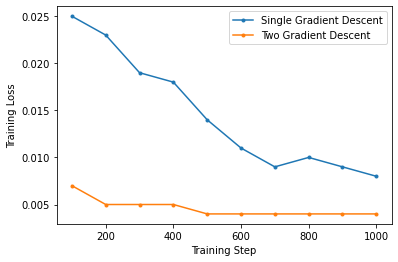

In [ ]:
data = [[0.025, 0.023, 0.019, 0.018, 0.014, 0.011, 0.009, 0.010, 0.009, 0.008], [0.007, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]]

x_ = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

#plt.title('Different activation function in GON')
plt.xlabel('Training Step')
plt.ylabel('Training Loss')
plt.plot(x_, data[0], marker = 'o', markersize = 3)
plt.plot(x_, data[1], marker = 'o', markersize = 3)


plt.legend(['Single Gradient Descent', 'Two Gradient Descent'])
plt.show()